# **Applying Deep Learning to Earth Observation - Assignment 4**

## Instructions

Work through the assignment 2 notebook, and use this notebook to provide your answers. Be aware that the code cell for `customDataset` in this template is with complete instruction. 

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment4_xyz.ipynb, with xyz again replaced by your initials.
- There are 50 points in this assignment, with an additional 5 extra credit. 

# **Theoretical questions**

## **Answer to Q1** 

a) Can you explain the limitations or drawbacks associated with each of the following methods used to extend the receptive field for deep learning in semantic segmentation:

- Using a larger kernel size for conv layers throughout the network. 

Using a larger kernal size for convolutional networks has two main drawbacks. First, it increases the number of parameters in the network, which can lead to overfitting. 
Second, and more crucially, it will result in a coarser feature map, and a loss of spatial resolution. 

So, though a larger kernal size can be advantageous in that it captures more contextual informationn from the previous layer, if it gets too large it will reduce spatial resolution. 

- Increasing the depth of the network by stacking more convolutional layers.

- Downsampling using pooling or convolution with a stride greater than 1.

- Using dilated convolutions.

(2.5 points)

b) What are the proposed solutions to the drawbacks of using dilated conv layers?

## **Answer to Q2**

## **Answer to Q3**

# **Continue with our pipeline implementation**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
%%capture
!pip install rasterio

In [4]:
import os
import re
import math
from pathlib import Path
from datetime import datetime, timedelta
import tqdm
import pandas as pd
import numpy as np
import cv2
import random
import rasterio
from natsort import natsorted

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace
from IPython.display import Image

In [5]:
print("PyTorch version: {}".format(torch.__version__))
print("Cuda version : {}".format(torch.version.cuda))
print('CUDNN version:', torch.backends.cudnn.version())
print('Number of available GPU Devices:', torch.cuda.device_count())
print("current GPU Device: {}".format(torch.cuda.current_device()))

PyTorch version: 2.0.0+cu118
Cuda version : 11.8
CUDNN version: 8700
Number of available GPU Devices: 1
current GPU Device: 0


## **Pre-process the input dataset**

Example code is provided below, which will allow you to get up and running with this assignment. However, you will learn best if you use the code you developed/modified from previous assignments to do the work, as you will start to see how it all fits together. 

In [6]:
#@title Add code for input normalization or use the existing one

def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) : Absolute path to the image patch.
    dtype (numpy datatype) : data type of the normalized image default is "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)

    # Return the normalized image data
    return normalized_img

In [7]:
#@title Add the image augmentations functions of your choice here, or use the code below

def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either 
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)
        
        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)
        
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)
        
        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)
        
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
        
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()


def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle 
            (in degrees) respectively. If number of elements are bigger than 2, 
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], 
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], 
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

For assignment 4, you are working with a dataset called "PondDataset" which consists pairs of already chipped image and labels of size: `256x256` and pixel values are already in the range of `[0, 1]`. 

**Structure:**

![PondDataset](https://drive.google.com/uc?export=view&id=12Nuy_mVXSAQpnfmpOdycnLBxeEOajMSe)

You can find the dataset in the shared drive, which is [here](https://drive.google.com/drive/folders/1hJKRa1tNQmglErELsIEk8hXEykJadmKh?usp=share_link). Please download the entire "PondDataset" folder and place it in a convenient locations in your own Google Drive 

Now you have to adapt your `ActiveLoadingDataset` from reading a "csv file", to walk through the folder structure and grab all the "tiff" files for "image" and "label" folders.



## Coding Assignment Part 1



As stated above, you can adapt the code below, or you can use your own loader and adapt it as needed for this assignment. In this case, you need to modify the loader so that it can read chips from a directory, rather than just reading a CSV.  



In [8]:
from sys import settrace
#@title Add custom dataset from previous assignment and modify to fit the requirements of assignment 4

import os

class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, dataset_name, usage, apply_normalization=False, 
                 transform=None, **kargs):
        r"""
        src_dir (str or path): Root of resource directory.
        dataset_name (str): Name of the training/validation dataset containing 
                              structured folders for image, label
        usage (str): Either 'train' or 'validation'.
        transform (list): Each element is string name of the transformation to  
           be used.
        """
        self.src_dir = src_dir
        self.dataset_name = dataset_name
        self.apply_normalization = apply_normalization
        self.transform = transform
        
        self.usage = usage
        assert self.usage in ["train", "validation"], "Usage is not recognized."

        #img_dir = "/content/drive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images" / self.dataset_name / self.usage / transform
 

        lbl_path = Path(src_dir) / dataset_name / self.usage / 'labels'
        

                ###### Add your code here. ######
        # hint: you need two lines of code or less: 
        #       2- make a list of filenames for the files with the ".tif" 
        #          extension using os.walk and preferably list comprehension
        #       3- sort the list of tif files.

        # Create an empty list to store the TIFF files
        lbl_files = []

        # use os.walk() to traverse the directory tree
        for dirpath, dirnames, filenames in os.walk(lbl_path):
          # iterate over the filenames in the current directory
          for filename in filenames:
            # check if the file has the specified extension
            if filename.lower().endswith(('.tif', '.tiff')):
              # If the file is a TIFF file, add it to the list
              lbl_files.append(os.path.join(dirpath, filename))

              #file_path = os.path.join(dirpath, filename)
              #print(file_path)

        # Print the list of TIFF files
        #print(lbl_files)

        lbl_files = natsorted(lbl_files)

        img_path = Path(src_dir) / dataset_name / self.usage / 'images'

                ###### Add your code here. ######
        # hint: you need two lines of code or less: 
        #       2- make a list of filenames for the files with the ".tif" 
        #          extension using os.walk and preferably list comprehension
        #       3- sort the list of tif files.

        # Create an empty list to store the TIFF files
        img_files = []

        # use os.walk() to traverse the directory tree
        for dirpath, dirnames, filenames in os.walk(img_path):
          # iterate over the filenames in the current directory
          for filename in filenames:
            # check if the file has the specified extension
            if filename.lower().endswith(('.tif', '.tiff')):
              # If the file is a TIFF file, add it to the list
              img_files.append(os.path.join(dirpath, filename))

              file_path = os.path.join(dirpath, filename)
              #print(file_path)

        #set_trace()
        # Print the list of TIFF files
        img_files = natsorted(img_files)
        print(img_files)


                ##### Add your code here #####
        # Hint: iterate through the list of string paths from the image and 
        # label lists, load the data, transpose image to have channels as the 
        # last dimension and add them to 'img_chips' and 'lbl_chips' containers.

        self.img_chips = []
        self.lbl_chips = []
        
        for i in img_files:
          with rasterio.open(i) as src:
            # Print some metadata about the image
            #print(src.profile)
            # Access the image data as a numpy array
            image_array = src.read()
            if apply_normalization==True:
                image_array=min_max_normalize_image(image_array)
            image_array = image_array.transpose(1,2,0)
            self.img_chips.append(image_array)
        #print(self.img_chips)


        for i in lbl_files:
          with rasterio.open(i) as src:
            # Print some metadata about the image
            #print(src.profile)
            # Access the image data as a numpy array
            label_array = src.read(1)
            self.lbl_chips.append(label_array)
        #print(self.lbl_chips)
            


        
        
        print('--------{} patches cropped--------'.format(len(self.img_chips)))
        

    def __getitem__(self, index):

        image_chip = self.img_chips[index]
        label_chip = self.lbl_chips[index]

        # Change the code if you are using a different augmentation
        if self.usage == "train" and self.transform:
            
            trans_flip_ls = [m for m in self.transform if "flip" in m]
            if random.randint(0, 1) and len(trans_flip_ls) > 1:
                trans_flip = random.sample(trans_flip_ls, 1)[0]
                image_chip, label_chip = flip_image_and_label(
                    image_chip, label_chip, trans_flip
                )
            
            if random.randint(0, 1) and "rotate" in self.transform:
                img_chip, lbl_chip = rotate_image_and_label(
                    image_chip, label_chip, angle=[0,90]
                )

        # Convert numpy arrays to torch tensors.
        # Image chips should be in 'CHW' order, if not transpose to correct 
        # order of dimensions.
        ##### Add code here #####
        # create the two tensors here for the output below, using the correct 
        # reshaping functions
        image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
        label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()
      

        return image_tensor, label_tensor

    def __len__(self):

        return len(self.img_chips)

**Loading your data**

In [9]:
src_dir = "/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4"
dataset_name = "PondDataset"
usage = "train"
transform = ["hflip", "vflip", "rotate"]

In [10]:
train_dataset = ActiveLoadingDataset(src_dir, dataset_name, usage, 
                 transform)

['/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip1.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip2.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip3.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip4.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip5.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip7.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip8.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/

In [10]:
test_img = train_dataset[0][0]

In [ ]:
#sorted_list = sorted(tiff_files, key=lambda x: int(re.findall(r'\d+',x.split('_')[-1])[0]))

In [11]:
import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image(image_array, cmap="grey", band_composite=None, stretch=None):
    r"""
    Plots a loaded image using matplotlib and rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        stretch (str) : A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        cmap (str) : A string specifying the color map to use for the image 
            (default:'gray').
        band_composite (tuple of int) : A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    if ((image_array.ndim == 3) and 
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]

    # If a band composite is specified, create an RGB image
    if band_composite:
        # Get the individual bands
        red_band = image_array[:, :, band_composite[0] - 1]
        green_band = image_array[:, :, band_composite[1] - 1]
        blue_band = image_array[:, :, band_composite[2] - 1]

        # Stack the bands to create an RGB image
        rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

        # Apply the contrast stretch if specified
        if stretch:
            p_min, p_max = np.percentile(rgb_image, (2, 98))
            stretched = exposure.rescale_intensity(
                rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = rgb_image

        # Display the RGB image using matplotlib
        ax.imshow(stretched)
    
    # Otherwise, display the single-band image
    else:
        if stretch:
            p_min, p_max = np.percentile(image_array, (2, 98))
            stretched = exposure.rescale_intensity(
                image_array, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = image_array
        
        # Display the image using rasterio.plot.show
        rp.show(stretched, ax=ax, cmap=cmap)


    # Add a title and axis labels
    ax.set_title('Image')
    ax.set_xlabel(f'# Column: {image_size[0]}')
    ax.set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    plt.show()

TypeError: ignored

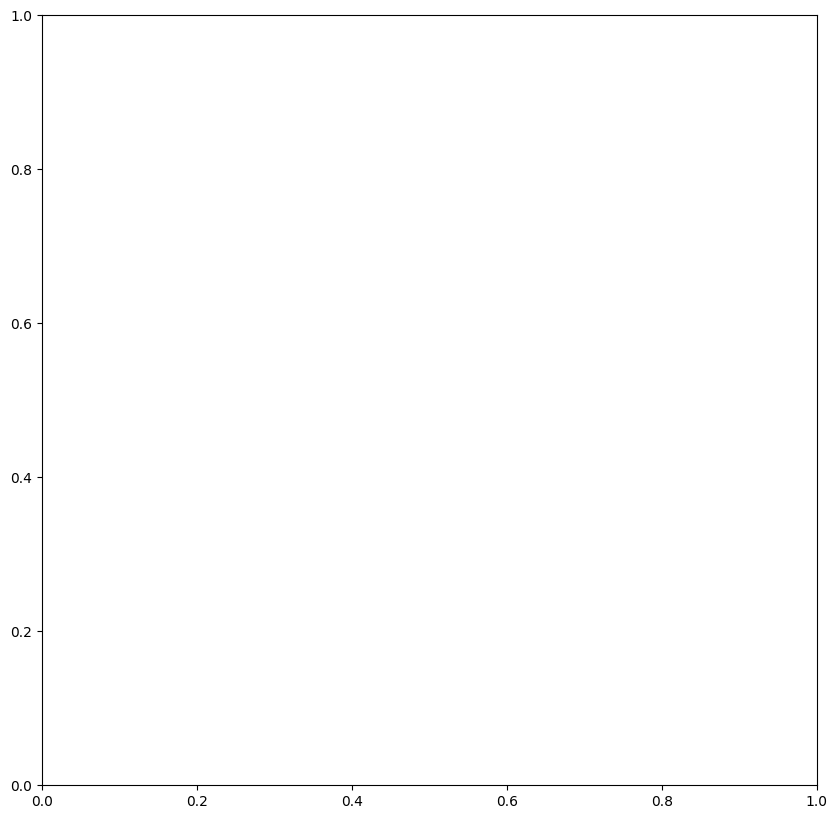

In [12]:
band_composite=(2,1,0)
stretch = True
plot_image(test_img, band_composite=band_composite, stretch=stretch)

In [12]:
train_loader = DataLoader(train_dataset,
                          batch_size = 16, 
                          shuffle = True)

In [13]:
validation_dataset = ActiveLoadingDataset(src_dir, dataset_name, 
                                          usage="validation", 
                                          apply_normalization=False)

['/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip14.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip18.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip21.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip28.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip29.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip32.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip33.tif', '/content/gdrive/MyDrive/C

In [14]:
val_loader = DataLoader(validation_dataset, batch_size = 1, shuffle = False)

## **Model architecture**

For your reference I have added a complete Unet architecture.

In [15]:
#@title Add the Unet model you have designed from assignment 3 or use the existing one.


class ConvBlock(nn.Module):
    r"""This module creates a user-defined number of conv+BN+ReLU layers.
    Args:
        in_channels (int)-- number of input features.
        out_channels (int) -- number of output features.
        kernel_size (int) -- Size of convolution kernel.
        stride (int) -- decides how jumpy kernel moves along the spatial 
            dimensions.
        padding (int) -- how much the input should be padded on the borders with 
            zero.
        dilation (int) -- dilation ratio for enlarging the receptive field.
        num_conv_layers (int) -- Number of conv+BN+ReLU layers in the block.
        drop_rate (float) -- dropout rate at the end of the block.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, num_conv_layers=2, drop_rate=0):
        super(ConvBlock, self).__init__()

        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                            stride=stride, padding=padding, dilation=dilation, 
                            bias=False),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True), ]

        if num_conv_layers > 1:
            if drop_rate > 0:
                layers += [
                    nn.Conv2d(out_channels, out_channels, 
                              kernel_size=kernel_size, stride=stride, 
                              padding=padding, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
                    nn.Dropout(drop_rate), 
                ] * (num_conv_layers - 1)
            else:
                layers += [
                    nn.Conv2d(out_channels, out_channels, 
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True), 
                ] * (num_conv_layers - 1)

        self.block = nn.Sequential(*layers)

    def forward(self, inputs):
        outputs = self.block(inputs)
        return outputs

###########################################################################

class UpconvBlock(nn.Module):
    r"""
    Decoder layer decodes the features along the expansive path.
    Args:
        in_channels (int) -- number of input features.
        out_channels (int) -- number of output features.
        upmode (str) -- Upsampling type. If "fixed" then a linear upsampling with scale factor
                        of two will be applied using bi-linear as interpolation method.
                        If deconv_1 is chosen then a non-overlapping transposed convolution will
                        be applied to upsample the feature maps. If deconv_1 is chosen then an
                        overlapping transposed convolution will be applied to upsample the feature maps.
    """

    def __init__(self, in_channels, out_channels, upmode="deconv_1"):
        super(UpconvBlock, self).__init__()

        if upmode == "fixed":
            layers = [nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True), ]
            layers += [nn.BatchNorm2d(in_channels),
                       nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False), ]

        elif upmode == "deconv_1":
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0, dilation=1), ]

        elif upmode == "deconv_2":
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, dilation=1), ]

        # Dense Upscaling Convolution
        elif upmode == "DUC":
            up_factor = 2
            upsample_dim = (up_factor ** 2) * out_channels
            layers = [nn.Conv2d(in_channels, upsample_dim, kernel_size=3, padding=1),
                      nn.BatchNorm2d(upsample_dim),
                      nn.ReLU(inplace=True),
                      nn.PixelShuffle(up_factor), ]

        else:
            raise ValueError("Provided upsampling mode is not recognized.")

        self.block = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.block(inputs)


###########################################################################

class Unet(nn.Module):
    def __init__(self, n_classes, in_channels, filter_config=None, dropout_rate=0):
        super(Unet, self).__init__()

        self.in_channels = in_channels

        if not filter_config:
            filter_config = (64, 128, 256, 512, 1024, 2048)

        assert len(filter_config) == 6

        # Contraction Path
        self.encoder_1 = ConvBlock(self.in_channels, filter_config[0], num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 64x256x256
        self.encoder_2 = ConvBlock(filter_config[0], filter_config[1], num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 128x128x128
        self.encoder_3 = ConvBlock(filter_config[1], filter_config[2], num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 256x64x64
        self.encoder_4 = ConvBlock(filter_config[2], filter_config[3], num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 512x32x32
        self.encoder_5 = ConvBlock(filter_config[3], filter_config[4], num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 1024x16x16
        self.encoder_6 = ConvBlock(filter_config[4], filter_config[5], num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 2048x8x8
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansion Path
        self.decoder_1 = UpconvBlock(filter_config[5], filter_config[4], upmode="deconv_2")  # 1024x16x16
        self.conv1 = ConvBlock(filter_config[4] * 2, filter_config[4], num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_2 = UpconvBlock(filter_config[4], filter_config[3], upmode="deconv_2")  # 512x32x32
        self.conv2 = ConvBlock(filter_config[4], filter_config[3], num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_3 = UpconvBlock(filter_config[3], filter_config[2], upmode="deconv_2")  # 256x64x64
        self.conv3 = ConvBlock(filter_config[3], filter_config[2], num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_4 = UpconvBlock(filter_config[2], filter_config[1], upmode="deconv_2")  # 128x128x128
        self.conv4 = ConvBlock(filter_config[2], filter_config[1], num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_5 = UpconvBlock(filter_config[1], filter_config[0], upmode="deconv_2")  # 64x256x256
        self.conv5 = ConvBlock(filter_config[1], filter_config[0], num_conv_layers=2, drop_rate=dropout_rate)

        self.classifier = nn.Conv2d(filter_config[0], n_classes, kernel_size=1, stride=1, padding=0)  # classNumx256x256

    def forward(self, inputs):
        # set_trace()
        e1 = self.encoder_1(inputs)  # batch size x 64 x 256 x 256
        p1 = self.pool(e1)  # batch size x 64 x 128 x 128

        e2 = self.encoder_2(p1)  # batch size x 128 x 128 x 128
        p2 = self.pool(e2)  # batch size x 128 x 64 x 64

        e3 = self.encoder_3(p2)  # batch size x 256 x 64 x 64
        p3 = self.pool(e3)  # batch size x 256 x 32 x 32

        e4 = self.encoder_4(p3)  # batch size x 512 x 32 x 32
        p4 = self.pool(e4)  # batch size x 1024 x 16 x 16

        e5 = self.encoder_5(p4)  # batch size x 1024 x 16 x 16
        p5 = self.pool(e5)  # batch size x 1024 x 8 x 8

        e6 = self.encoder_6(p5)  # batch size x 2048 x 8 x 8

        d6 = self.decoder_1(e6)  # batch size x 1024 x 16 x 16

        
        skip1 = torch.cat((e5, d6), dim=1)  # batch size x 2048 x 16 x 16

        d6_proper = self.conv1(skip1)  # batch size x 1024 x 16 x 16

        d5 = self.decoder_2(d6_proper)  # batch size x 512 x 32 x 32

        skip2 = torch.cat((e4, d5), dim=1)  # batch size x 1024 x 32 x 32

        d5_proper = self.conv2(skip2)  # batch size x 512 x 32 x 32

        d4 = self.decoder_3(d5_proper)  # batch size x 256 x 64 x 64

        skip3 = torch.cat((e3, d4), dim=1)  # batch size x 512 x 64 x 64

        d4_proper = self.conv3(skip3)  # batch size x 256 x 64 x 64

        d3 = self.decoder_4(d4_proper)  # batch size x 128 x 128 x 128

        skip4 = torch.cat((e2, d3), dim=1)  # batch size x 256 x 128 x 128

        d3_proper = self.conv4(skip4)  # batch size x 128 x 128 x 128

        d2 = self.decoder_5(d3_proper)  # batch size x 64 x 256 x 256

        skip5 = torch.cat((e1, d2), dim=1)  # batch size x 128 x 256 x 256

        d2_proper = self.conv5(skip5)  # batch size x 64 x 256 x 256

        d1 = self.classifier(d2_proper)  # batch size x classNum x 256 x 256

        return d1

**Initializing your model**

In [16]:
n_classes = 2
in_channels = 6
filter_config = (32, 64, 128, 256, 512, 1024)
dropout_rate = 0.15

In [17]:
model = Unet(n_classes, in_channels, filter_config, dropout_rate)

## **Customized loss function**

You will want to add two here, which you can copy from the main assignment notebook. 

In [18]:
#@title Add your choices of loss function here 

class BalancedCrossEntropyLoss(nn.Module):
    '''
    Balanced cross entropy loss by weighting of inverse class ratio
    Params:
        ignore_index (int): Class index to ignore
        reduction (str): Reduction method to apply to loss, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    '''

    def __init__(self, ignore_index=-100, reduction='mean'):
        super(BalancedCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, predict, target):
        # get class weights
        class_counts = torch.bincount(target.view(-1), minlength=predict.shape[1])
        class_weights = 1.0 / torch.sqrt(class_counts.float())

        # set weight of ignore index to 0
        if self.ignore_index >= 0 and self.ignore_index < len(class_weights):
            class_weights[self.ignore_index] = 0

        # normalize weights
        class_weights /= torch.sum(class_weights)

        # apply class weights to loss function
        loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=self.ignore_index, reduction=self.reduction)

        return loss_fn(predict, target)


class BinaryDiceLoss(nn.Module):
    '''
        Dice loss of binary class
        Params:
            smooth (float): A float number to smooth loss, and avoid NaN error, default: 1
            p (int): Denominator value: \sum{x^p} + \sum{y^p}, default: 2. Used
                     to control the sensitivity of the loss.
            predict (torch.tensor): Predicted tensor of shape [N, *]
            target (torch.tensor): Target tensor of same shape with predict
        Returns:
            Loss tensor
    '''
    def __init__(self, smooth=1, p=1):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
    #set_trace()

    def forward(self, predict, target):
        #set_trace()

        assert predict.shape == target.shape, "predict & target shape do not match"
        predict = predict.contiguous().view(-1)
        target = target.contiguous().view(-1)

        num = 2 * (predict * target).sum() + self.smooth
        den = (predict.pow(self.p) + target.pow(self.p)).sum() + self.smooth
        loss = 1 - num / den

        return loss


class DiceLoss(nn.Module):
    '''
        Dice loss
        Params:
            weight (torch.tensor): Weight array of shape [num_classes,]
            ignore_index (int): Class index to ignore
            predict (torch.tensor): Predicted tensor of shape [N, C, *]
            target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
            reduction (str): Reduction method.
        Returns:
            same as BinaryDiceLoss
    '''
    def __init__(self, weight=None, ignore_index=-100, smooth=1, p=1, reduction='sum'):
        super(DiceLoss, self).__init__()
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.dice = BinaryDiceLoss(smooth, p)
        if weight is not None:
            self.weight = weight.cuda()
        else:
            self.weight = None

    def forward(self, predict, target):
        #set_trace()
        if predict.shape == target.shape:
            pass
        elif len(predict.shape) == 4:
            target = F.one_hot(target, num_classes=predict.shape[1]).permute(0, 3, 1, 2).contiguous()
        else:
            assert 'predict shape not applicable'

        self.weight = torch.Tensor([1. / predict.shape[1]] * predict.shape[1]).cuda() if self.weight is None else self.weight
        predict = F.softmax(predict, dim=1)

        if self.ignore_index >= 0:
            target = torch.where(target == self.ignore_index, torch.zeros_like(target), target)
            predict = torch.where(target == self.ignore_index, torch.zeros_like(predict), predict)

        total_loss = 0
        for i in range(predict.shape[1]):
            dice_loss = self.dice(predict[:, i], target[:, i])

            assert self.weight.shape[0] == predict.shape[1], \
                    'Expect weight shape [{}], get[{}]'.format(predict.shape[1], self.weight.shape[0])
            dice_loss *= self.weight[i]
            total_loss += dice_loss

        if self.reduction == 'mean':
            loss = total_loss / predict.shape[1]
        elif self.reduction == 'sum':
            loss = total_loss

        return loss

## **Coding assignment part 2**: training the network



In the sections below you need to complete the three functions that you need to train and validate the network over a specified number of epochs  

**HOW To:**

Properly use the "criterion" argument inside the "train" and "validation" functions:
Pass the argument to the function as a string with `()` like: "BalancedCrossEntropyLoss()"

Now as you try to use the argument inside both "train" and "validation" functions, use `eval()` like: 

`loss = eval(criterion)(tensor A, tensor B)`

**Note:**

`eval()` is a built-in Python function that allows you to evaluate a string expression as a Python code. It takes a string as an argument and evaluates the expression contained in it. The result of the evaluation is then returned.

In [19]:
#@title Complete the function to optimize over a batch of training images and labels
def train(trainData, model, optimizer, criterion, gpu=True, train_loss=[]):
    """
        Train the model using provided training dataset.
        Params:
            trainData (DataLoader object) -- Batches of image chips from PyTorch 
                custom dataset (AquacultureData).
            model -- Choice of segmentation model.
            optimizer -- Chosen optimization algorithm to update model parameters.
            criterion -- Chosen function to calculate loss over training samples.
            gpu (bool, optional) -- Decide whether to use GPU, default is True.
            train_loss (empty list, optional) -- ???????????????????????????
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.train()

    # Mini batch iteration
    train_epoch_loss = 0
    train_batches = len(trainData)

    for img_chips, labels in trainData:

        #Add code to put image and label on the 'device'.
        # one line for each.

        # Add code to clear the 'optimizer' from existing gradients (1 line)
        # Pass image through the model to obtain prediction (1 line)
        # calculate loss based on 'model prediction' and label (1 line)
        # Add current loss (loss.item()) to 'train_epoch_loss' counter (1 line)
        # do the backward pass to calculate gradients with respect to the loss (1 line)
        # update model weights by invoking the proper method on 'optimizer'

        img = img_chips.to(device)
        label = labels.to(device)

        optimizer.zero_grad()

        pred = model(img)

        loss = eval(criterion)(pred, label)
        train_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss.append(train_epoch_loss / train_batches)
    print('Training loss: {:.4f}'.format(train_epoch_loss / train_batches))

Besides training the network, it's important to evaluate its performance on a separate "validation dataset" to ensure that it's not overfitting to the training data. The validation process is similar to the training process, but the network is set to evaluation mode using `model.eval()` and the gradients are not computed.

In [20]:
#@title Complete the function to iterate validation images and labels


def validate(valData, model, criterion, device, val_loss=[]):
    """
        Evaluate the model on separate Landsat scenes.
        Params:
            valData (DataLoader object) -- Batches of image chips from PyTorch custom dataset(AquacultureData)
            model -- Choice of segmentation Model.
            criterion -- Chosen function to calculate loss over validation samples.
            buffer: Buffer added to the targeted grid when creating dataset. This allows loss to calculate
                at non-buffered region.
            gpu (binary,optional): Decide whether to use GPU, default is True
            valLoss (empty list): To record average loss for each epoch
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()

    # mini batch iteration
    eval_epoch_loss = 0

    for img_chips, labels in valData:

        img = Variable(img_chips, requires_grad=False)
        label = Variable(labels, requires_grad=False)

        #Add code to put image and label on the 'device'.
        # one line for each.

        img = img_chips.to(device)
        label = labels.to(device)

        pred = model(img)

        loss = eval(criterion)(pred, label)
        eval_epoch_loss += loss.item()

        # Pass image through the model to obtain prediction (1 line)
        # calculate loss based on 'model prediction' and label (1 line)
        # Add current loss (loss.item()) to 'train_epoch_loss' counter (1 line)

    print('validation loss: {}'.format(eval_epoch_loss / len(valData)))

    if val_loss != None:
        val_loss.append(float(eval_epoch_loss / len(valData)))


In [21]:
#@title Complete the function to iterate over the desired number of epochs

def epochIterater(trainData, valData, model, criterion, WorkingFolder, initial_lr, num_epochs):
    r"""
    Epoch iteration for train and evaluation.
    
    Arguments:
    trainData (dataloader object): Batch grouped data to train the model.
    evalData (dataloader object): Batch grouped data to evaluate the model.
    model (pytorch.nn.module object): initialized model.
    initial_lr(float): The initial learning rate.
    num_epochs (int): User-defined number of epochs to run the model.
    
    """

    train_loss = []
    val_loss = []
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device.type == "cuda":
        print('----------GPU available----------')
        gpu = True
        model = model.to(device)
    else:
        print('----------No GPU available, using CPU instead----------')
        gpu = False
        model = model
    
    writer = SummaryWriter(WorkingFolder)
    optimizer = optim.Adam(model.parameters(),
                           lr=initial_lr,
                           betas=(0.9, 0.999),
                           eps=1e-08,
                           weight_decay=5e-4,
                           amsgrad=False)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=3,
                                          gamma=0.98)
    
    # Add your code here
    # you need to loop through the epochs and perform the following:
    # print the current epoch number out of the total epochs (e.g. "epoch: 2/10")(1 line)
    # start the timer (1 line)
    # do model fit on the training data for single epoch (1 line)
    # do model validation on the validation dataset for one epoch (1 line)
    # take a step to update the 'scheduler'. (1 line)
    # Print the updated learning rate.
    # use "add_scalars" method with your writer to save the train and validation loss to graph
    # using tensorboard package later. 
    
    for t in range(num_epochs):
        print("Epoch [{}/{}]".format(t + 1, num_epochs))
        start_epoch = datetime.now()

        train(trainData, model, optimizer, criterion, device, train_loss=train_loss)
        validate(valData, model, criterion, device, val_loss=val_loss)

        scheduler.step()
        print("LR: {}".format(scheduler.get_last_lr()))

        writer.add_scalars("Loss", 
                           {"train loss": train_loss[t],
                            "validation loss": val_loss[t]},
                           t + 1)


    writer.close()

    duration_in_sec = (datetime.now() - start_epoch).seconds
    duration_format = str(timedelta(seconds=duration_in_sec))
    print("--------------- Training finished in {} ---------------".format(duration_format))

### Demonstrate the code
Run the model training and validation for a specified number of epochs (e.g. 15), and then save the results. Train / validate twice, once using your first loss function, and again using your second loss function.  





In [32]:
src_dir = "/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4"
dataset_name = "PondDataset"
transform = ["hflip", "vflip", "rotate"]

n_classes = 2
in_channels = 6
filter_config = (32, 64, 128, 256, 512, 1024)
dropout_rate = 0.1

criterion1 = "BalancedCrossEntropyLoss()"
criterion2= "DiceLoss()"
WorkingFolder1 = "/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/Test2/Model1"
WorkingFolder2 = "/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/Test2/Model2"
initial_lr = 0.01
num_epochs = 20
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
model = Unet(n_classes, 
             in_channels, 
             filter_config, 
             dropout_rate)

In [24]:
trainData = ActiveLoadingDataset(src_dir, dataset_name, usage="train", 
                 transform=transform)

['/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip1.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip2.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip3.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip4.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip5.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip7.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip8.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/

In [ ]:
valData = ActiveLoadingDataset(src_dir, dataset_name, usage="validation", transform=transform)

['/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip14.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip18.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip21.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip28.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip29.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip32.tif', '/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/validation/images/LC08_L1TP_011062_20171013_20171024_01_T1_band_chip33.tif', '/content/gdrive/MyDrive/C

In [33]:
#@title Train/validate 1
epochIterater(train_loader, val_loader, model, criterion1, WorkingFolder=WorkingFolder1, initial_lr=initial_lr, num_epochs=num_epochs)

----------GPU available----------
Epoch [1/20]
Training loss: 0.3213
validation loss: 0.4432431158092287
LR: [0.01]
Epoch [2/20]
Training loss: 0.2673
validation loss: 0.4420091410477956
LR: [0.01]
Epoch [3/20]
Training loss: 0.2601
validation loss: 0.4897676014237934
LR: [0.0098]
Epoch [4/20]
Training loss: 0.2508
validation loss: 0.6229907522598902
LR: [0.0098]
Epoch [5/20]
Training loss: 0.2482
validation loss: 0.3738890442583296
LR: [0.0098]
Epoch [6/20]
Training loss: 0.2195
validation loss: 0.6669526131616699
LR: [0.009604]
Epoch [7/20]
Training loss: 0.2195
validation loss: 0.5800267931487825
LR: [0.009604]
Epoch [8/20]
Training loss: 0.2085
validation loss: 0.4925929792225361
LR: [0.009604]
Epoch [9/20]
Training loss: 0.2251
validation loss: 0.5693371976415317
LR: [0.009411919999999999]
Epoch [10/20]
Training loss: 0.2181
validation loss: 0.46988641826642885
LR: [0.009411919999999999]
Epoch [11/20]
Training loss: 0.2071
validation loss: 0.42978638741705155
LR: [0.00941191999999

In [34]:
#@title Save model results 1 in a directory of choice in your gdrive
torch.save(model.state_dict(), 
           os.path.join(Path(WorkingFolder1), "lab4_1.pth"))

In [ ]:
epochIterater(train_loader, val_loader, model, criterion2, WorkingFolder=WorkingFolder2, initial_lr=initial_lr, num_epochs=num_epochs)

----------GPU available----------
Epoch [1/20]
Training loss: 0.1469
validation loss: 0.26750268538792926
LR: [0.01]
Epoch [2/20]
Training loss: 0.1329
validation loss: 0.3338363501760695
LR: [0.01]
Epoch [3/20]
Training loss: 0.1264
validation loss: 0.36063040693600973
LR: [0.0098]
Epoch [4/20]
Training loss: 0.1313
validation loss: 0.530811220407486
LR: [0.0098]
Epoch [5/20]
Training loss: 0.1312
validation loss: 0.339750830994712
LR: [0.0098]
Epoch [6/20]
Training loss: 0.1239
validation loss: 0.33120519783761765
LR: [0.009604]
Epoch [7/20]
Training loss: 0.1155
validation loss: 0.2588106267982059
LR: [0.009604]
Epoch [8/20]
Training loss: 0.1145
validation loss: 0.3094512217574649
LR: [0.009604]
Epoch [9/20]
Training loss: 0.1013
validation loss: 0.561220559808943
LR: [0.009411919999999999]
Epoch [10/20]
Training loss: 0.0970
validation loss: 0.35638334419992235
LR: [0.009411919999999999]
Epoch [11/20]
Training loss: 0.1043
validation loss: 0.23629060122701856
LR: [0.00941191999999

In [ ]:
#@title Save model results 2 in a directory of choice in your gdrive
torch.save(model.state_dict(), 
           os.path.join(Path(WorkingFolder2), "lab4_2.pth"))

## **Evaluation and accuracy metrics**

**Note:**

If you have disconnected from the Colab session or restarted the kernel, then before doing the evaluation on the validation dataset you must initialize your model once more and load the trained weights onto your model.

In [25]:
#@title code for metric class

class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

## Coding Assignment Part 3

Complete the code to undertake model evaluation below. Evaluate twice: once for each model trained with a different loss function.  

In [26]:
#@title Add the code for evaluation here

def do_accuracy_evaluation(model, dataloader, num_classes):
    evaluator = Evaluator(num_classes)

    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            # add batch to evaluator
            evaluator.add_batch(labels.cpu().numpy(), preds.cpu().numpy())

    # calculate evaluation metrics
    pixel_accuracy = evaluator.Pixel_Accuracy()
    mean_accuracy = evaluator.Pixel_Accuracy_Class()
    mean_IoU = evaluator.Mean_Intersection_over_Union()
    frequency_weighted_IoU = evaluator.Frequency_Weighted_Intersection_over_Union()

    print("pixel accuracy is: ", pixel_accuracy)
    print("mean accuracy is: ", mean_accuracy)
    print("mean IoU is: ", mean_IoU)
    print("frequency weighted IoU is: ", frequency_weighted_IoU)

    return pixel_accuracy, mean_accuracy, mean_IoU, frequency_weighted_IoU
    

In [27]:
#@title Demonstrate evaluation of model 1
model1 = Unet(n_classes, in_channels, filter_config, dropout_rate)
model1.load_state_dict(torch.load('/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/Test1/lab4_1.pth'))
#/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/Test1/lab4_1.pth
test1 = do_accuracy_evaluation(model1.cuda(), val_loader, 2)


pixel accuracy is:  0.8401207817925347
mean accuracy is:  0.7153929017780729
mean IoU is:  0.6051273557979839
frequency weighted IoU is:  0.7353683536018227


In [28]:
#@title Demonstrate evaluation of model 2
#@title Demonstrate evaluation of model 1
model2 = Unet(n_classes, in_channels, filter_config, dropout_rate)
model2.load_state_dict(torch.load('/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/Test1/lab4_2.pth'))
#/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/Test1/lab4_1.pth
test2 = do_accuracy_evaluation(model2.cuda(), val_loader, 2)

pixel accuracy is:  0.8485677083333333
mean accuracy is:  0.678725968875955
mean IoU is:  0.5893341420053981
frequency weighted IoU is:  0.7371547622354631


## **Visualizing activation maps and learned kernels from intermidiate layers in the network**

In [29]:
#Load the multispectral satellite image
with rasterio.open("/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/PondDataset/train/images/LC08_L1TP_011060_20190426_20190426_01_RT_band_chip1.tif") as dataset:
    # Read the image data as a numpy array and reshape to HWC
    image = dataset.read().transpose([1, 2, 0])

# Normalize the image data to be between 0 and 1
image = min_max_normalize_image(image, dtype=np.float32)

# Convert the image to a PyTorch tensor and add a batch dimension
image_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [35]:
# Define the CNN model and load the pre-trained weights
model = Unet(n_classes, in_channels, filter_config, dropout_rate)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Clark/Deep_Learning/Lab4/Test2/Model1/lab4_1.pth'))

print(model)

Unet(
  (encoder_1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder_2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

In [36]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [37]:
# Visualize the activation map for a particular layer

layer_index = 2  # Choose the index of the layer to visualize (0-indexed)
layer_name = f'conv{layer_index + 1}'  # Layer name for displaying in the plot title
activation = {}

In [38]:
# Set the model to evaluation mode
model.eval()

model.conv1.register_forward_hook(get_activation(layer_name))

with torch.no_grad():
    model(image_tensor)

activation = activation.squeeze().numpy()

plt.imshow(activation[layer_index])
plt.title(f'Activation Map for {layer_name}')
plt.show()

AttributeError: ignored